# Introduction

The model is a Generative Adversarial Network (GAN) that generates molecular structures in the form of SMILES (Simplified Molecular Input Line Entry System) strings. The model consists of two main components: a generator and a discriminator.

The generator takes a latent vector as input and generates a sequence of tokens representing a SMILES string. The discriminator takes a SMILES string as input and outputs a probability that the string was generated by the real data distribution rather than the generator.

The generator and discriminator are trained together using a two-step process. In the first step, the discriminator is trained to distinguish between real and fake SMILES strings. In the second step, the generator is trained to generate SMILES strings that are indistinguishable from real SMILES strings by maximizing the reward function, which is the difference between the discriminator's output for the generated string and the baseline reward.

The training process involves the following steps:

1. Sample a batch of real SMILES strings from the training data.
2. Sample a batch of latent vectors from the latent space.
3. Generate a batch of fake SMILES strings using the generator and the latent vectors.
4. Train the discriminator to distinguish between real and fake SMILES strings.
5. Train the generator to generate SMILES strings that are indistinguishable from real SMILES strings by maximizing the reward function.
6. Repeat steps 2-5 for a specified number of training steps.

After training, the generator can be used to generate new molecular structures by sampling latent vectors from the latent space and passing them through the generator. The output of the generator is a sequence of tokens representing a SMILES string, which can be converted to a molecular structure using a chemical library such as RDKit.

In the code below, the `MolGen` class is used to train the GAN on a dataset of molecular structures in SMILES format. The `generate_n` method of the `MolGen` class can be used to generate a specified number of new molecular structures, and the `Chem.MolFromSmiles` function from the RDKit library can be used to convert the generated SMILES strings to molecular structures.

# Dataset

In [18]:
import pandas as pd
df = pd.read_csv("/kaggle/working/molgen/qm9.csv")

In [20]:
df.head()

,mol_id,smiles,A,B,C,mu,alpha,homo,lumo,gap,...,zpve,u0,u298,h298,g298,cv,u0_atom,u298_atom,h298_atom,g298_atom
0,gdb_1,C,157.71180,157.709970,157.706990,0.0000,13.21,-0.3877,0.1171,0.5048,...,0.044749,-40.478930,-40.476062,-40.475117,-40.498597,6.469,-395.999595,-398.643290,-401.014647,-372.471772
1,gdb_2,N,293.60975,293.541110,191.393970,1.6256,9.46,-0.2570,0.0829,0.3399,...,0.034358,-56.525887,-56.523026,-56.522082,-56.544961,6.316,-276.861363,-278.620271,-280.399259,-259.338802
2,gdb_3,O,799.58812,437.903860,282.945450,1.8511,6.31,-0.2928,0.0687,0.3615,...,0.021375,-76.404702,-76.401867,-76.400922,-76.422349,6.002,-213.087624,-213.974294,-215.159658,-201.407171
3,gdb_4,C#C,0.00000,35.610036,35.610036,0.0000,16.28,-0.2845,0.0506,0.3351,...,0.026841,-77.308427,-77.305527,-77.304583,-77.327429,8.574,-385.501997,-387.237686,-389.016047,-365.800724
4,gdb_5,C#N,0.00000,44.593883,44.593883,2.8937,12.99,-0.3604,0.0191,0.3796,...,0.016601,-93.411888,-93.409370,-93.408425,-93.431246,6.278,-301.820534,-302.906752,-304.091489,-288.720028


In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 133885 entries, 0 to 133884
Data columns (total 21 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   mol_id     133885 non-null  object 
 1   smiles     133885 non-null  object 
 2   A          133885 non-null  float64
 3   B          133885 non-null  float64
 4   C          133885 non-null  float64
 5   mu         133885 non-null  float64
 6   alpha      133885 non-null  float64
 7   homo       133885 non-null  float64
 8   lumo       133885 non-null  float64
 9   gap        133885 non-null  float64
 10  r2         133885 non-null  float64
 11  zpve       133885 non-null  float64
 12  u0         133885 non-null  float64
 13  u298       133885 non-null  float64
 14  h298       133885 non-null  float64
 15  g298       133885 non-null  float64
 16  cv         133885 non-null  float64
 17  u0_atom    133885 non-null  float64
 18  u298_atom  133885 non-null  float64
 19  h298_atom  133885 non-n

In [ ]:
# !pip install -r /kaggle/working/molgen/requirement.txt

In [ ]:
# !pip install --upgrade huggingface-hub==0.24.0

In [4]:
import huggingface_hub
print(huggingface_hub.__version__)

0.24.0


# Loading Data and Initializing 

In [3]:
from rdkit import Chem
from model import MolGen

# load data
data = []
with open('/kaggle/working/molgen/qm9.csv', "r") as f:
    for line in f.readlines()[1:]:
        data.append(line.split(",")[1])

# create model
gan_mol = MolGen(data, hidden_dim=64, lr=1e-3, device="cuda")

2024-07-28 15:33:12.692113: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-28 15:33:12.692174: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-28 15:33:12.693765: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [17]:
gan_mol

MolGen(
  (generator): Generator(
    (embedding_layer): Embedding(23, 64)
    (project): FeedForward(
      (_activations): ModuleList(
        (0): ReLU()
        (1): ELU(alpha=0.1)
      )
      (_linear_layers): ModuleList(
        (0): Linear(in_features=64, out_features=128, bias=True)
        (1): Linear(in_features=128, out_features=128, bias=True)
      )
      (_dropout): ModuleList(
        (0): Dropout(p=0.1, inplace=False)
        (1): Dropout(p=0.1, inplace=False)
      )
    )
    (rnn): LSTMCell(64, 64)
    (output_layer): Sequential(
      (0): ReLU()
      (1): Dropout(p=0.1, inplace=False)
      (2): Linear(in_features=64, out_features=128, bias=True)
      (3): ReLU()
      (4): Dropout(p=0.1, inplace=False)
      (5): Linear(in_features=128, out_features=22, bias=True)
    )
  )
  (discriminator): RecurrentDiscriminator(
    (embedding): Embedding(24, 64, padding_idx=0)
    (rnn): LstmSeq2SeqEncoder(
      (_module): LSTM(64, 64, batch_first=True, bidirectional=Tr

# Training

In [5]:
# create dataloader
loader = gan_mol.create_dataloader(data, batch_size=128, shuffle=True, num_workers=10)

# train model for 10000 steps
gan_mol.train_n_steps(loader, max_step=20000, evaluate_every=100)

/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:563: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


['((H5]n3]n#oNC]4=+(C', '2F4)(3=)n1=2[332oc)']
valid =  0.01
['O1OOCCO(())C(OC1OC', 'CC']
valid =  0.06
['11CC23C12', 'Cc1n#(1']
valid =  0.03
['CCCcC=OCNC', 'CCCC1CO)CcC']
valid =  0.06
['CC3C', 'C2CNO(CCNNC']
valid =  0.09
['CCCOCC1', 'CCN)C(C2Cn']
valid =  0.10
['OC(C1C3CCCN1', 'NCC1CC2OC1=C=CN3']
valid =  0.03
['CCN=CC1N1CC2C1H=O', 'CC1CNC2C112COCO13CC']
valid =  0.06
['C=OC1C(C', 'CC1CC=C=C=OC11C[']
valid =  0.04
['COCOC1', 'CCNC1CC1']
valid =  0.20
['N2C1OCC12', 'NCON#CCOC1']
valid =  0.20


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


['OC1CcC1=CN=O', 'OC1CCC2']
valid =  0.13
['OC12C1CC2OC#N', 'OC1CC1CN1=O']
valid =  0.19
['OCC1OCCC2CC1N', 'CCC=OC1']
valid =  0.11
['OC1C2CCOC1nC1', 'CC12OC12NCC2']
valid =  0.04
['OCCC12CC#CCCOC1O', 'OCCC1C=NCC1OCC12']
valid =  0.09
['CC1CNC2OC1C2C=C2CN)', 'C=CCN1=COC1C2O']
valid =  0.10
['OC1OC2OC1C1O=O', 'O=C1CC1OCC21O']
valid =  0.13
['CC1CCCOC=CC1O', 'CC1CC2OCC1CCC=O']
valid =  0.23
['CN1=CCOC1', 'OC1CC1C21CC2OC1C=O']
valid =  0.16
['N=OCC12CC1COC12', 'C1CCOC12CC1C=N']
valid =  0.14
['C#CCOC1C1C2COC21', 'OC1CC2CC1COC2']
valid =  0.21
['O=C1CC1CNC1', 'O=COC1C=CC1CC1']
valid =  0.24
['C#CC1CC=CO1', 'CC12CCC121OC=N']
valid =  0.20
['COC1CC1CC1C', 'O=CCCCCCC1OC=N']
valid =  0.48
['O=CCC1CC1OCC1=O', 'O=OC1C1CC#CC1NC1C1']
valid =  0.26
['CCO1CCC1NC1C', 'N=C1NC1C=CN1CNC1=O']
valid =  0.40
['C3CC1CC2N3C1C2=N', 'C1C2NC=NC2C1C#C']
valid =  0.27
['OCC12CC2CC112C2', 'C1CC2NC12']
valid =  0.40
['C1OC=CN1CC=CCN=CO1', 'CC1C1OC11CCNC11CC1=']
valid =  0.37
['CC1CC2C1COC23', 'COC1CCOCC1=N']
valid 

In [6]:
gan_mol.eval()

print('ok')

ok


# Generating Smiles

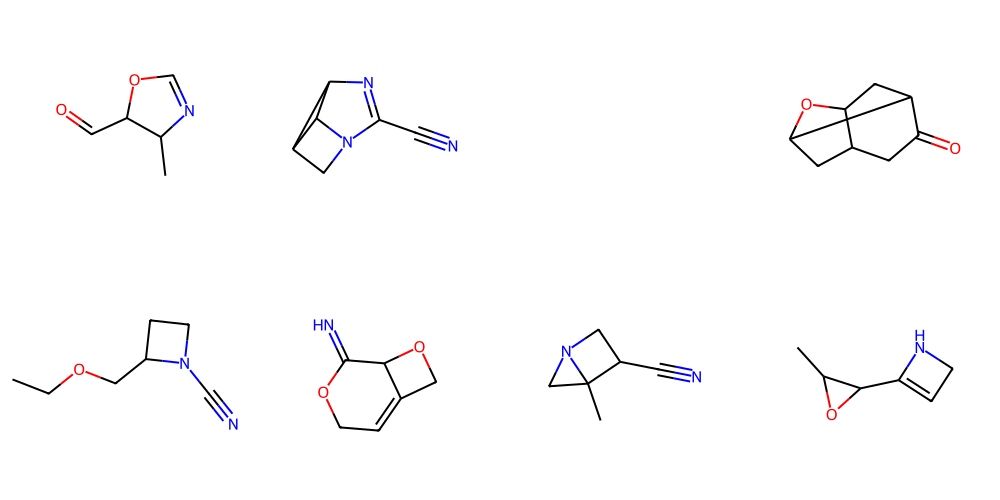

In [7]:
# After training
# generate Smiles molecules
smiles_list = gan_mol.generate_n(8)

# convert with rdkit
mol_list = [Chem.MolFromSmiles(m) for m in smiles_list]

# draw
Chem.Draw.MolsToGridImage(mol_list, molsPerRow=4, subImgSize=(250, 250), maxMols=10)

In [14]:
smiles_list

['CC1N=COC1C=O',
 'N#CC1=NC2C3CN1C23',
 'O=CCCC#CC11CO1',
 'O=C1CC2CC3OC2CC13',
 'CCOCC1CCN1C#N',
 'N=C1OCC=C2COC12',
 'CC12CN1CC2C#N',
 'CC1OC1C1=CCN1']

In [21]:
mol_list

 None,

The none in `mol_list` indicates that it is not valid.

In [ ]:
# dir(gan_mol)

# Saving and loading model

In [11]:
# Save model
import torch
torch.save(gan_mol.state_dict(), 'gan_mol_dict.pth')


In [24]:
# Load model
gan_mol_n = MolGen(data, hidden_dim=64, lr=1e-3, device="cuda")

# Load the state dictionary into the new model
gan_mol_n.load_state_dict(torch.load('gan_mol_dict.pth'))

# Print the loaded model state to verify
# print("Loaded model state:", gan_mol_n.state_dict())

<All keys matched successfully>

In [27]:
gan_mol_n.eval()

print('ok')

ok


/opt/conda/lib/python3.10/site-packages/rdkit/Chem/Draw/IPythonConsole.py:261: UserWarning: Truncating the list of molecules to be displayed to 10. Change the maxMols value to display more.
  warnings.warn(


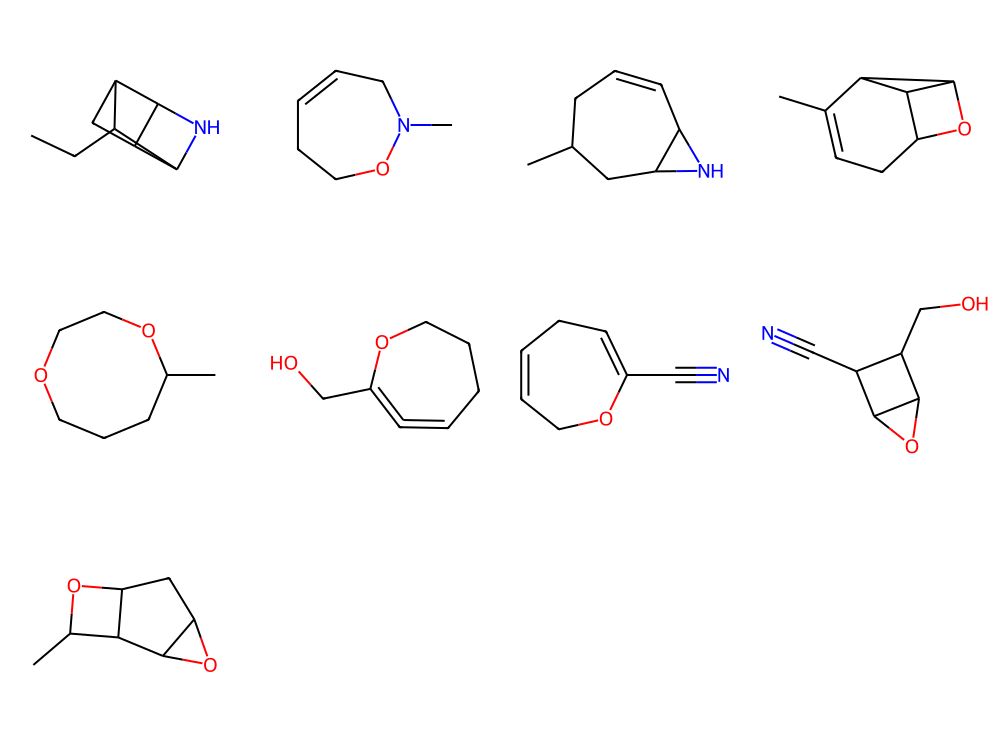

In [28]:
# After training
# generate Smiles molecules
smiles_list = gan_mol_n.generate_n(12)

# convert with rdkit
mol_list = [Chem.MolFromSmiles(m) for m in smiles_list]

# draw
Chem.Draw.MolsToGridImage(mol_list, molsPerRow=4, subImgSize=(250, 250), maxMols=10)